<center><span style='font-size:40px'>Методы подбора гиперпараметров </span><center>

In [105]:
# импортируем библиотеки
import numpy as np #для матричных вычислений
import pandas as pd #для анализа и предобработки данных
import matplotlib.pyplot as plt #для визуализации
import seaborn as sns #для визуализации
import warnings

warnings.filterwarnings('ignore')


from sklearn import linear_model #линейные моделиё
from sklearn import tree #деревья решений
from sklearn import ensemble #ансамбли
from sklearn import metrics #метрики
from sklearn import preprocessing #предобработка
from sklearn.model_selection import train_test_split #сплитование выборки
from sklearn.model_selection import KFold, cross_validate #кросс-валидация

%matplotlib inline
plt.style.use('bmh')

In [16]:
data = pd.read_csv('data\_train_sem09 (1).csv')
data

,Activity,D1,D2,D3,D4,D5,D6,D7,D8,D9,...,D1767,D1768,D1769,D1770,D1771,D1772,D1773,D1774,D1775,D1776
0,1,0.000000,0.497009,0.10,0.0,0.132956,0.678031,0.273166,0.585445,0.743663,...,0,0,0,0,0,0,0,0,0,0
1,1,0.366667,0.606291,0.05,0.0,0.111209,0.803455,0.106105,0.411754,0.836582,...,1,1,1,1,0,1,0,0,1,0
2,1,0.033300,0.480124,0.00,0.0,0.209791,0.610350,0.356453,0.517720,0.679051,...,0,0,0,0,0,0,0,0,0,0
3,1,0.000000,0.538825,0.00,0.5,0.196344,0.724230,0.235606,0.288764,0.805110,...,0,0,0,0,0,0,0,0,0,0
4,0,0.100000,0.517794,0.00,0.0,0.494734,0.781422,0.154361,0.303809,0.812646,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3746,1,0.033300,0.506409,0.10,0.0,0.209887,0.633426,0.297659,0.376124,0.727093,...,0,0,0,0,0,0,0,0,0,0
3747,1,0.133333,0.651023,0.15,0.0,0.151154,0.766505,0.170876,0.404546,0.787935,...,0,0,1,0,1,0,1,0,0,0
3748,0,0.200000,0.520564,0.00,0.0,0.179949,0.768785,0.177341,0.471179,0.872241,...,0,0,0,0,0,0,0,0,0,0
3749,1,0.100000,0.765646,0.00,0.0,0.536954,0.634936,0.342713,0.447162,0.672689,...,0,0,0,0,0,0,0,0,0,0


In [17]:
data.duplicated(subset=data.columns).sum()

0

In [18]:
data.isna().sum().sum()

0

Пропусков и дубликатов нет.

In [19]:
# Зададим константное значение 
random_state = 42

<Axes: xlabel='Activity', ylabel='count'>

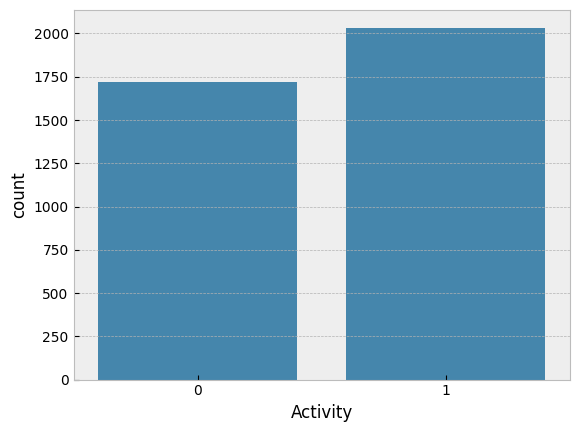

In [20]:
sns.countplot(data, x='Activity', orient='v')

Как видим, значений Activity, равным 0, немного меньше, чем значений 1. Воспользуемся стратифицированным разделением.

In [21]:
# Разделим фичи и целевой признак по отдельным переменным
X = data.drop('Activity', axis=1)
y = data['Activity']
# Делим датафрейм на тренировочный и валидационный
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=random_state)
print(X_train.shape, X_test.shape)

(3000, 1776) (751, 1776)


Посмотрим на целевую метрику - f1 score - при дефолтных значениях гиперпараметров модели.

In [22]:
# Создаём модель логистической регрессии
log_reg_model = linear_model.LogisticRegression(max_iter=1000, random_state=random_state,)
# Обучим модель и оценим её качество при дефолтных гиперпараметрах
log_reg_model.fit(X_train, y_train)

print('default logreg test f1-score: {}'.format(round(metrics.f1_score(y_test, log_reg_model.predict(X_test)), 2)))

default logreg test f1-score: 0.78


In [23]:
# Создаём модель случайного леса
rnd_forest_model = ensemble.RandomForestClassifier(random_state=random_state)
# Обучим модель и оценим её качество при дефолтных гиперпараметрах
rnd_forest_model.fit(X_train, y_train)
    
print('default random forest test f1-score: {}'.format(round(metrics.f1_score(y_test, rnd_forest_model.predict(X_test)), 2)))

default random forest test f1-score: 0.8


# GridSearchCV

In [24]:
from sklearn.model_selection import GridSearchCV

<span style="font-size:28px">Logistic Regression</span>

In [25]:
# Задаём сетку параметров
param_grid = {
    'penalty': ['l1', 'l2'],
    'C': [0.01, 0.1, 0.2, 0.4, 0.8, 1, 2.5, 4],
    'solver': ['liblinear', 'sag', 'newton-cholesky']
}

grid_searcher = GridSearchCV(
    estimator = linear_model.LogisticRegression(random_state=random_state, max_iter=1000),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

%time grid_searcher.fit(X_train, y_train)
print('f1-score by GridSearchCV: {}'.format(round(metrics.f1_score(y_test, grid_searcher.predict(X_test)), 2)))
print('best parameters by GridSearchCV: {}'.format(grid_searcher.best_params_))

CPU times: total: 1.47 s
Wall time: 2min 56s
f1-score by GridSearchCV: 0.78
best parameters by GridSearchCV: {'C': 0.2, 'penalty': 'l1', 'solver': 'liblinear'}


Как видим, f1-метрика никак не улучшилась по сравнению с дефолтными параметрами логистической регрессии, а по времени затратили целых 3 минуты вместо 0.5 секунд.

---

<span style='font-size:28px'>Random Forest Classifier</span>

In [26]:
# Задаём сетку параметров
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': list(np.linspace(3, 30, 5, dtype=int)),
    'min_samples_leaf': list(np.linspace(5, 50, 5, dtype=int))
}

grid_searcher = GridSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=random_state),
    param_grid=param_grid,
    cv=5,
    n_jobs = -1
)

%time grid_searcher.fit(X_train, y_train)
print('f1-score by GridSearchCV: {}'.format(round(metrics.f1_score(y_test, grid_searcher.predict(X_test)), 2)))
print('best parameters by GridSearchCV: {}'.format(grid_searcher.best_params_))

CPU times: total: 2.42 s
Wall time: 38.3 s
f1-score by GridSearchCV: 0.8
best parameters by GridSearchCV: {'criterion': 'entropy', 'max_depth': 16, 'min_samples_leaf': 5}


Для случайного леса метрика тоже осталась на том же уровне по сравнению с дефолтными значениями, хотя времени на выполнение кода затратилось меньше, чем для логистической регресии.

# RandomizedSearchCV

In [27]:
from sklearn.model_selection import RandomizedSearchCV

<span style="font-size:28px">Logistic Regression</span>

In [28]:
# Задаём сетку параметров
param_distributions = {
    'penalty': ['l1', 'l2', None],
    'C': [0.01, 0.1, 0.2, 0.4, 0.8, 1, 2.5, 4],
    'solver': ['liblinear', 'sag', 'newton-cholesky']
}

randomized_grid_searcher = RandomizedSearchCV(
    estimator = linear_model.LogisticRegression(random_state=random_state, max_iter=1000),
    param_distributions=param_distributions,
    cv=5,
    n_iter=50,
    n_jobs = -1
)

%time randomized_grid_searcher.fit(X_train, y_train)
print('f1-score by GridSearchCV: {}'.format(round(metrics.f1_score(y_test, randomized_grid_searcher.predict(X_test)), 2)))
print('best parameters by GridSearchCV: {}'.format(randomized_grid_searcher.best_params_))

CPU times: total: 3.28 s
Wall time: 4min 51s
f1-score by GridSearchCV: 0.78
best parameters by GridSearchCV: {'solver': 'liblinear', 'penalty': 'l1', 'C': 0.2}


RandomizedSearchCV предсказал те же параметры, что и обычный GridSearch. Времени потребовалось больше, чем в прошлый раз.

<span style='font-size:28px'>Random Forest Classifier</span>

In [29]:
# Задаём сетку параметров
params = {
    'n_estimators': list(range(100, 200, 30)),
    'criterion': ['gini', 'entropy'],
    'max_depth': list(np.linspace(10, 50, 30, dtype=int)),
    'min_samples_leaf': list(np.linspace(5, 50, 5, dtype=int))
}

rand_grid_searcher = RandomizedSearchCV(
    estimator = ensemble.RandomForestClassifier(random_state=random_state),
    param_distributions=params,
    cv=5,
    n_iter=50,
    n_jobs = -1
)

%time rand_grid_searcher.fit(X_train, y_train)
print('f1-score by RandomizedSearchCV: {}'.format(round(metrics.f1_score(y_test, rand_grid_searcher.predict(X_test)), 2)))
print('best parameters by RandomizedSearchCV: {}'.format(rand_grid_searcher.best_params_))

CPU times: total: 2.89 s
Wall time: 1min
f1-score by RandomizedSearchCV: 0.79
best parameters by RandomizedSearchCV: {'n_estimators': 160, 'min_samples_leaf': 5, 'max_depth': 21, 'criterion': 'entropy'}


Для случайного леса метрика осталась примерно на том же уровне, что и для дефолтных значений, хотя времени на выполнение кода затратилось меньше, чем для логистической регресии. Помимо этого, мы смогли подобрать еще и оптимальное кол-во деревьев решений.

# Hyperopt

In [30]:
from hyperopt import hp, tpe, Trials, fmin

<span style="font-size:28px">Logistic Regression</span>

In [31]:
# пространство поиска параметров
space = {
    'penalty': hp.choice('penalty', ['l1', 'l2']),
    'C': hp.quniform('C', 0.1, 1, 0.1),
    'solver': hp.choice('solver', ['liblinear', 'sag', 'newton-cholesky', 'saga'])
}

# функция, с помощью которой находится максимальное значение метрики
def hyperopt_func(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    try: 
        # задаём пространство поиска параметров внутри функции
        params = {
            'penalty': params['penalty'],
            'C': params['C'],
            'solver': params['solver']
        }
        # создаём и обучаем модель
        model = linear_model.LogisticRegression(**params, random_state=random_state)
        model.fit(X_train, y_train)
        # считаем метрику
        score = metrics.f1_score(y_test, model.predict(X_test))
        # т.к. функция fmin находит минимумы, будем возвращать отрицательные значения
        return -score
    except ValueError:
        return float('inf')

In [32]:
# задаём "хранилище" гиперпараметров
trials = Trials()

best_params = fmin(
    hyperopt_func,
    space=space,
    max_evals=25,
    algo=tpe.suggest,
    trials=trials,
    rstate=np.random.default_rng(random_state)
)

print("Наилучшие значения гиперпараметров {}".format(best_params))

100%|██████████| 25/25 [00:46<00:00,  1.87s/trial, best loss: -0.7857142857142857]
Наилучшие значения гиперпараметров {'C': 0.1, 'penalty': 1, 'solver': 1}


In [33]:
# Hyperopt возвращает индексы для категориальных гиперпараметров, найдём истинные значения
best_params['penalty'] = ['l1', 'l2'][best_params['penalty']]
best_params['solver'] = ['liblinear', 'sag', 'newton-cholesky', 'saga'][best_params['solver']]
best_params

{'C': 0.1, 'penalty': 'l2', 'solver': 'sag'}

In [34]:
log_reg_model = linear_model.LogisticRegression(**best_params, random_state=random_state, max_iter=1000)
log_reg_model.fit(X_train, y_train)
print('best f1-score by Hyperopt: {}'.format(round(metrics.f1_score(y_test, log_reg_model.predict(X_test)), 2)))

best f1-score by Hyperopt: 0.79


Hyperopt определил отличный от методов "сетки" набор гиперпараметров, который показал пока что лучший результат f1 метрики, и к тому же код выполнился быстрее всех.

<span style='font-size:28px'>Random Forest Classifier</span>

In [35]:
# пространство поиска параметров
space = {
    'criterion': hp.choice('criterion', ['gini', 'entropy', 'logloss']),
    'n_estimators': hp.quniform('n_estimators', 100, 300, 10),
    'max_depth': hp.quniform('max_depth', 5, 70, 5),
    'min_samples_leaf': hp.quniform('min_samples_leaf', 5, 100, 5)
}

# функция, с помощью которой находится максимальное значение метрики
def hyperopt_func(params, cv=5, X=X_train, y=y_train, random_state=random_state):
    try: 
        # задаём пространство поиска параметров внутри функции
        params = {
            'criterion': params['criterion'],
            'n_estimators': int(params['n_estimators']),
            'max_depth': int(params['max_depth']),
            'min_samples_leaf': int(params['min_samples_leaf'])
        }
        # создаём и обучаем модель
        model = ensemble.RandomForestClassifier(**params, random_state=random_state)
        model.fit(X_train, y_train)
        # считаем метрику
        score = metrics.f1_score(y_test, model.predict(X_test))
        # т.к. функция fmin находит минимумы, будем возвращать отрицательные значения
        return -score
    except ValueError:
        return float('inf')

In [36]:
# задаём "хранилище" гиперпараметров
trials = Trials()

best_params = fmin(
    hyperopt_func,
    space=space,
    max_evals=50,
    algo=tpe.suggest,
    trials=trials,
    rstate=np.random.default_rng(random_state)
)

print("Наилучшие значения гиперпараметров {}".format(best_params))

100%|██████████| 50/50 [01:00<00:00,  1.20s/trial, best loss: -0.7995169082125604]
Наилучшие значения гиперпараметров {'criterion': 1, 'max_depth': 40.0, 'min_samples_leaf': 5.0, 'n_estimators': 210.0}


In [37]:
# Hyperopt возвращает индексы для категориальных гиперпараметров, найдём истинные значения
best_params['criterion'] = ['gini', 'entropy', 'logloss'][best_params['criterion']]
# Также Hyperopt возвращает числа типа float, нужно поменять формат на integer
for i in best_params.keys():
    if i != 'criterion':
        best_params[i] = int(best_params[i])
        

rnd_forest_model = ensemble.RandomForestClassifier(**best_params, random_state=random_state)
rnd_forest_model.fit(X_train, y_train)

print('best f1-score by Hyperopt: {}'.format(round(metrics.f1_score(y_test, rnd_forest_model.predict(X_test)), 2)))

best f1-score by Hyperopt: 0.8


Для RandomForestClassifier Hyperopt не показал улучшения метрики и, вдобавок, модель обрабатывалась дольше, чем при использовании "сеток".

array([<Axes: >, <Axes: >, <Axes: >, <Axes: >], dtype=object)

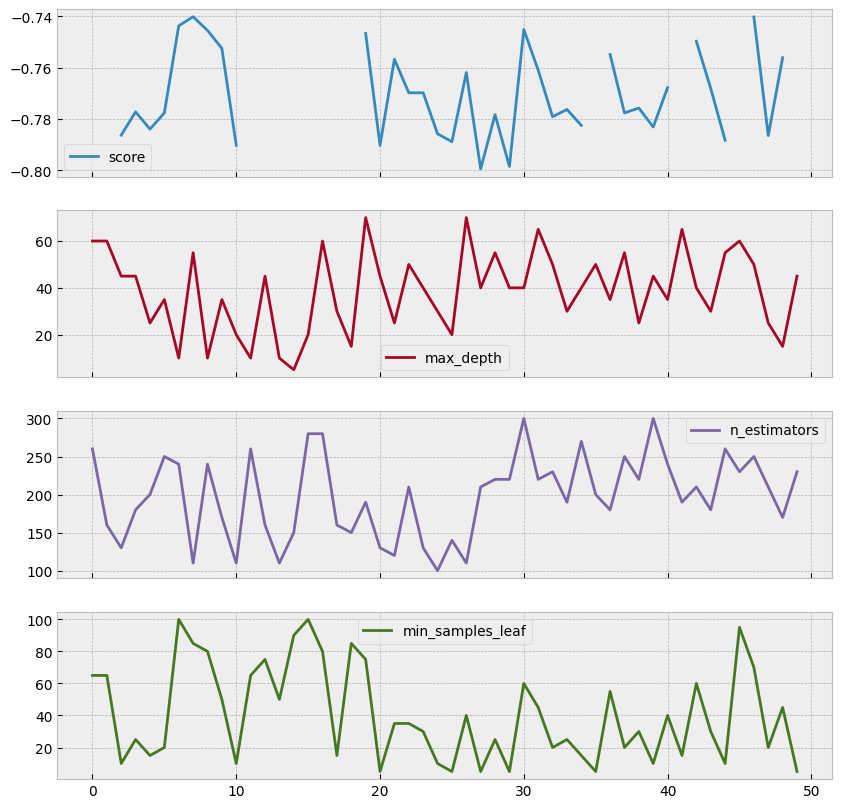

In [38]:
# отрисуем, как менялась точность при различных гиперпараметрах
tpe_results=np.array([[x['result']['loss'],
                      x['misc']['vals']['max_depth'][0],
                      x['misc']['vals']['n_estimators'][0],
                      x['misc']['vals']['min_samples_leaf'][0]] for x in trials.trials])

tpe_results_df=pd.DataFrame(tpe_results,
                           columns=['score', 'max_depth', 'n_estimators', 'min_samples_leaf'])
# тепловая карта в данном случае не очень наглядна, возьмем линейный график
tpe_results_df.plot(subplots=True,figsize=(10, 10))

# Optuna

In [39]:
import optuna

<span style="font-size:28px">Logistic Regression</span>

In [91]:
# Напишем функцию, которая будет возвращать f1 метрику для подбора лучших гиперпараметров через Optuna
def optuna_func(obj):
    try:
        penalty = obj.suggest_categorical('penalty', ['l1', 'l2'])
        C = obj.suggest_categorical('C', [round(i * 0.1, 1) for i in range(1, 11)])
        solver = obj.suggest_categorical('solver', ['liblinear', 'sag', 'newton-cholesky', 'saga'])
            
        model = linear_model.LogisticRegression(penalty=penalty,
                                                    C=C,
                                                    solver=solver,
                                                    random_state=random_state)
        model.fit(X_train, y_train)
            
        return metrics.f1_score(y_test, model.predict(X_test))
    except ValueError:  
        
        return -float('inf')
    

# Создаём объект исследования
study = optuna.create_study(study_name='LogisticRegression', direction='maximize')
study.optimize(optuna_func, n_trials=25)

[I 2024-08-10 21:20:10,150] A new study created in memory with name: LogisticRegression
[I 2024-08-10 21:20:13,456] Trial 0 finished with value: 0.7705314009661836 and parameters: {'penalty': 'l2', 'C': 0.8, 'solver': 'sag'}. Best is trial 0 with value: 0.7705314009661836.
[I 2024-08-10 21:20:13,458] Trial 1 finished with value: -inf and parameters: {'penalty': 'l1', 'C': 0.7, 'solver': 'newton-cholesky'}. Best is trial 0 with value: 0.7705314009661836.
[I 2024-08-10 21:20:13,882] Trial 2 finished with value: 0.7783132530120482 and parameters: {'penalty': 'l2', 'C': 0.9, 'solver': 'liblinear'}. Best is trial 2 with value: 0.7783132530120482.
[I 2024-08-10 21:20:14,890] Trial 3 finished with value: 0.7857142857142857 and parameters: {'penalty': 'l2', 'C': 0.1, 'solver': 'newton-cholesky'}. Best is trial 3 with value: 0.7857142857142857.
[I 2024-08-10 21:20:18,530] Trial 4 finished with value: 0.781136638452237 and parameters: {'penalty': 'l2', 'C': 0.4, 'solver': 'saga'}. Best is trial 

In [92]:
optuna.visualization.plot_optimization_history(study, target_name='f1-score')

In [93]:
log_reg_model = linear_model.LogisticRegression(**study.best_params, random_state=random_state, max_iter=1000)
log_reg_model.fit(X_train, y_train)
print('best f1-score by Optuna: {}'.format(round(metrics.f1_score(y_test, log_reg_model.predict(X_test)), 2)))

best f1-score by Optuna: 0.79


Optuna отлично справился с задачей, показав лучшую метрику (как и Hyperopt) и выполнил задачу быстрее всех.

---

<span style='font-size:28px'>Random Forest Classifier</span>

In [100]:
# Напишем функцию, которая будет возвращать f1 метрику для подбора лучших гиперпараметров через Optuna
def optuna_func(obj):
    try:
        criterion = obj.suggest_categorical('criterion', ['gini', 'entropy', 'logloss'])
        n_estimators = obj.suggest_int('n_estimators', 100, 300, 10)
        max_depth = obj.suggest_int('max_depth', 5, 70, 5)
        min_samples_leaf = obj.suggest_int('min_samples_leaf', 5, 100, 5)
            
        model = ensemble.RandomForestClassifier(criterion=criterion,
                                                n_estimators=n_estimators,
                                                max_depth=max_depth,
                                                min_samples_leaf=min_samples_leaf,
                                                random_state=random_state)
        model.fit(X_train, y_train)
            
        return metrics.f1_score(y_test, model.predict(X_test))
    except ValueError:  
        
        return -float('inf')
    

# Создаём объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_func, n_trials=35)

[I 2024-08-10 21:31:21,862] A new study created in memory with name: RandomForestClassifier


[I 2024-08-10 21:31:22,623] Trial 0 finished with value: 0.7404674046740467 and parameters: {'criterion': 'gini', 'n_estimators': 160, 'max_depth': 35, 'min_samples_leaf': 90}. Best is trial 0 with value: 0.7404674046740467.
[I 2024-08-10 21:31:22,625] Trial 1 finished with value: -inf and parameters: {'criterion': 'logloss', 'n_estimators': 290, 'max_depth': 45, 'min_samples_leaf': 90}. Best is trial 0 with value: 0.7404674046740467.
[I 2024-08-10 21:31:22,627] Trial 2 finished with value: -inf and parameters: {'criterion': 'logloss', 'n_estimators': 250, 'max_depth': 60, 'min_samples_leaf': 50}. Best is trial 0 with value: 0.7404674046740467.
[I 2024-08-10 21:31:23,949] Trial 3 finished with value: 0.7800729040097205 and parameters: {'criterion': 'entropy', 'n_estimators': 150, 'max_depth': 45, 'min_samples_leaf': 20}. Best is trial 3 with value: 0.7800729040097205.
[I 2024-08-10 21:31:23,951] Trial 4 finished with value: -inf and parameters: {'criterion': 'logloss', 'n_estimators': 

In [101]:
optuna.visualization.plot_optimization_history(study, target_name='f1-score')

In [102]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
print('best f1-score by Optuna: {}'.format(round(metrics.f1_score(y_test, model.predict(X_test)), 2)))

best f1-score by Optuna: 0.8


Для случайных деревьев Optuna тоже показывает лучший результат и самую быструю работу.

# Кросс-валидация

Попробуем использовать кросс-валидацию вместе с Optuna - лучшим способом подбора гипермараметров. Будем использовать модель случайного леса, т.к. она показала себя лучше логистической регресии

In [112]:
# Напишем функцию, которая будет возвращать f1 метрику для подбора лучших гиперпараметров через Optuna
def optuna_func(obj):
    try:
        criterion = obj.suggest_categorical('criterion', ['gini', 'entropy', 'logloss'])
        n_estimators = obj.suggest_int('n_estimators', 100, 300, 10)
        max_depth = obj.suggest_int('max_depth', 5, 70, 5)
        min_samples_leaf = obj.suggest_int('min_samples_leaf', 5, 100, 5)
        
        model = ensemble.RandomForestClassifier(criterion=criterion,
                                                n_estimators=n_estimators,
                                                max_depth=max_depth,
                                                min_samples_leaf=min_samples_leaf,
                                                random_state=random_state)

        kf = KFold(n_splits=5)
        cv_metrics = cross_validate(estimator=model,
                                    cv=kf,
                                    X=X,
                                    y=y,
                                    scoring='f1')


        return np.mean(cv_metrics['test_score'])

    except ValueError:  
        
        return -float('inf')
    

# Создаём объект исследования
study = optuna.create_study(study_name='RandomForestClassifier', direction='maximize')
study.optimize(optuna_func, n_trials=25)

[I 2024-08-10 21:55:54,141] A new study created in memory with name: RandomForestClassifier
[I 2024-08-10 21:55:54,284] Trial 0 finished with value: -inf and parameters: {'criterion': 'logloss', 'n_estimators': 180, 'max_depth': 15, 'min_samples_leaf': 25}. Best is trial 0 with value: -inf.
[I 2024-08-10 21:56:00,831] Trial 1 finished with value: 0.7729324566989295 and parameters: {'criterion': 'gini', 'n_estimators': 200, 'max_depth': 10, 'min_samples_leaf': 30}. Best is trial 1 with value: 0.7729324566989295.
[I 2024-08-10 21:56:05,920] Trial 2 finished with value: 0.7711184294825058 and parameters: {'criterion': 'gini', 'n_estimators': 160, 'max_depth': 45, 'min_samples_leaf': 35}. Best is trial 1 with value: 0.7729324566989295.
[I 2024-08-10 21:56:11,969] Trial 3 finished with value: 0.7505227003819084 and parameters: {'criterion': 'entropy', 'n_estimators': 280, 'max_depth': 5, 'min_samples_leaf': 85}. Best is trial 1 with value: 0.7729324566989295.
[I 2024-08-10 21:56:15,769] Tri

In [113]:
optuna.visualization.plot_optimization_history(study, target_name='f1-score')

In [116]:
model = ensemble.RandomForestClassifier(**study.best_params, random_state=random_state)
model.fit(X_train, y_train)
print('best f1-score by Optuna & KFold-method: {}'.format(round(metrics.f1_score(y_test, model.predict(X_test)), 2)))

best f1-score by Optuna & KFold-method: 0.8


# Вывод

Во всех случаях метрика не сильно менялась, однако при использовании продвинутых методов оптимизации гиперпараметров (hyperopt и optuna), времени на выполнение кода затратилось меньше. Использование кросс-валидации только увеличило время выполнения кода, а результат остался тем же. 